# Learning to inverse (re-implementation)
This notebook attemps to re-implement the experiment described in
LEARNING TO INVERT: SIGNAL RECOVERY VIA DEEP CONVOLUTIONAL NETWORKS
(https://arxiv.org/pdf/1701.03891.pdf)

There might be some architecture difference (i.e. I use Batch Normalization but orginal DeepInverse doesn't) between this implementation and that described in DeepInverse.

The images are taken from is CIFAR-10.

In [1]:
# imports
import os

from six.moves import cPickle as pickle
import platform

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F

# import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter 
import ipdb

%matplotlib inline
# %matplotlib tk
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

print("Done")

Done


# Data preparation
I can't use the data loaded by torchvision directly. The data pairs should looks like (measurement, original) which is derived by $y = \Phi x$ (x is the orignal image, y is measurement)

I guess the paper has used **a fixed ** $\Phi ^T$ in the architecture. They **sweep** the range (as in Fig. 2 of the paper) to evaluate the method. (So this method just dismisses the existence of Restricted Isometry Property?)

In [2]:
# path_dataset = "D:\\dev_workspace\\Learning CNN\\cs231n_assignments\\spring1718_assignment2_v2\\cs231n\\datasets"
path_dataset = "D:\\dev_workspace\\Learning CNN\\cs231n_assignments\\spring1718_assignment2_v2\\cs231n\\datasets\\cifar-10-batches-py"

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

class Cifar10MeasurementDataset(Dataset):
    def _load_CIFAR_batch(self, filename):
        """ load single batch of cifar """
        with open(filename, 'rb') as f:
            datadict = load_pickle(f)
            _X = datadict['data']
            Y = datadict['labels']
#             X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
            # X = torch.tensor(X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(np.float), dtype=torch.float)
            X_rgb = torch.tensor(_X.reshape(10000, 3, 32, 32).astype(np.float), dtype=torch.float) / 255
            X = torch.empty(X_rgb.shape[0], 1, X_rgb.shape[2], X_rgb.shape[3], dtype=torch.float)
            # X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype(np.float) / 255
            # Y = np.array(Y)
            for i in range(X.shape[0]):
                X[i] = self.transform(X_rgb[i])
                # ipdb.set_trace()
            Y = torch.tensor(Y)
            return X, Y

    def _load_CIFAR10(self, ROOT, train_or_test):
        """ load all of cifar """
        xs = []
        ys = []
        if train_or_test == 'train':
            assert 1 <= self.cifar10_batch_range.start <= self.cifar10_batch_range.stop <= 6
            for b in self.cifar10_batch_range:   # for trial purpose we only load 1 batch (there are 5 in total)
                f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
                X, Y = self._load_CIFAR_batch(f)
                xs.append(X)
                ys.append(Y)
                del X, Y
            # Xtr = np.concatenate(xs)
            Xtr = torch.cat(xs)
            # Ytr = np.concatenate(ys)
            Ytr = torch.cat(ys)
            return Xtr, Ytr
        else: # 'test'
            Xte, Yte = self._load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
            return Xte, Yte
    
    def __init__(self, path_dataset, cifar10_batch_range=range(1,6), phi=None, train_or_test="train"):
        '''
        - path_dataset: str. The path to the CIFAR-10
        - cifar10_batch_range: Python range object. Specify the which batches to load
        - phi: torch.tensor. Should be None for trainning set. 
               For test set, we should pass the phi of training set to it
        - train_or_test: train set or test set
        '''
        self.cifar10_batch_range = cifar10_batch_range
        self.train_or_test = train_or_test
        self.transform = T.Compose(
            [
                T.ToPILImage(),
                T.Grayscale(),
                T.ToTensor(),
                T.Normalize([0.5], [0.5])
            ])
        # actually we dont need the `y`s (image label) in the cifar10. we merely want the images
        self.images, _dum = self._load_CIFAR10(path_dataset, train_or_test)
        # self.N = np.prod(self.images[0].shape)  # for rgb images
        self.N = self.images[0].shape[1] * self.images[0].shape[2]  # for grayscale images
        self.M = self.N // 2  # we do this for the time being
        if phi is None:
            # this is trainning set
            assert train_or_test == 'train', "test mode specified but no phi is given"
            self.phi = torch.randn(self.M, self.N)
        else:
            # this is test set
            assert train_or_test != 'train', "test mode specified but no phi is given"
            self.phi = phi
        # measurements = []
        x_tildes = []
        for im in self.images:
            # ipdb.set_trace()
            y = torch.mv(self.phi, im.view(-1) )
            x_tilde = torch.mv( self.phi.transpose(0,1), y)
            x_tilde = x_tilde.view(1, 1, 32, 32)  # view as 1-channel 32x32 image
#             ipdb.set_trace()
            x_tildes.append( x_tilde )
#             ipdb.set_trace()
        # self.measurements = torch.cat(measurements)
        self.x_tildes = torch.cat(x_tildes)
#         ipdb.set_trace()
    
    def __len__(self):
        '''provides the size of the dataset'''
        return len(self.images)
    
    def __getitem__(self, idx):
        '''
        supporting integer indexing in range from 0 to len(self) exclusive
        should return y = \Phi x (self.measurements)
        '''
        return (self.x_tildes[idx], self.images[idx])
    
# make an instance
train_set = Cifar10MeasurementDataset(path_dataset, range(1,6), train_or_test="train")
test_set = Cifar10MeasurementDataset(path_dataset, range(1), phi=train_set.phi, train_or_test="test")
print("Dataset loaded")

Dataset loaded


the_dataset: len=50000
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
before unnorm mx = 0.9686274528503418, mn=-1.0
mx = 0.9843137264251709, mn=0.0


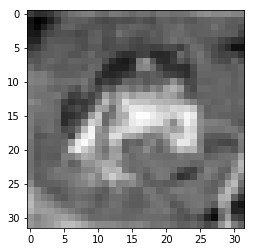

In [3]:
# test the instance
print(f'the_dataset: len={len(train_set)}')
# print(f'first sample is {train_set[0]}')
sample = train_set[0]
print(sample[0].shape)
print(sample[1].shape)
_im = sample[1].numpy()
print(f"before unnorm mx = {np.amax(_im)}, mn={np.amin(_im)}")

# unnormalize so that you can preview this image
_im = _im.transpose(1, 2, 0).astype(np.float)
# mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)  # for rgb
mean, std = (0.5,), (0.5,)
if _im.shape[2] == 1: # grayscale
    _im = _im.reshape(_im.shape[0], _im.shape[1])
    _im = _im * std[0] + mean[0]
else: # rgb
    for ch in range(3):
        _im[:,:,ch] = _im[:,:,ch] * std[ch] + mean[ch]
print(f"mx = {np.amax(_im)}, mn={np.amin(_im)}")
plt.imshow(_im.astype(np.float), cmap="gray")
plt.show()

In [4]:
#####################################################
# load dataset
NUM_TRAIN = int(0.8 * len(train_set) )
TOTAL_SAMPLES = len(train_set)

#####################################################

loader_train = DataLoader(train_set, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))


loader_test = DataLoader(test_set, batch_size=64)

#####################################################
# set up device
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [5]:
# Have a look at what the loader would return
train_iter = iter(loader_train)
_y, _x = train_iter.next()
print(_y.shape)

torch.Size([64, 1, 32, 32])


In [6]:
# The model
class DeepInverse(nn.Module):
    def _init_weights(self, m):
        print(m)
        if type(m) == nn.Conv2d:
            nn.init.kaiming_normal_(m.weight.data)
            nn.init.constant_(m.bias.data, 0)
#         if type(m) == nn.Linear:
#             nn.init.kaiming_normal_(m.weight.data)
#             nn.init.constant_(m.bias.data, 0)
    
    def __init__(self, mmat_shape):
        '''
        - mmat_shape: the shape of the measurement matrix
        '''
        super().__init__()
#         self.mmat_shape = mmat_shape
#         self.linear = nn.Linear(mmat_shape[0], mmat_shape[1], bias=False)
        self.conv_bundle = nn.Sequential(
            nn.Conv2d(1, 64, 11, stride=1, padding=5, dilation=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(64, 32, 11, stride=1, padding=5, dilation=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 1, 11, stride=1, padding=5, dilation=1),
            # nn.BatchNorm2d(1),
            nn.LeakyReLU()
        )
#         self.linear.apply(self._init_weights)
        self.conv_bundle.apply(self._init_weights)
        
        
    def forward(self, x):
#         ipdb.set_trace()
#         x = self.linear(x)
#         num_samples = x.shape[0]
#         x = x.view(num_samples, 3, 32, 32)  # view as 3-channel 32x32 image
        x = self.conv_bundle(x)  # should looks like some original image?
        
        return x

model = DeepInverse(train_set.phi.shape)
###############################
def sanity_check():
    train_iter = iter(loader_train)
    _y, _x = train_iter.next()
    with torch.no_grad():
        recovered_im = model(_y)
    print(recovered_im.size())  # you should see [64, 1, 32, 32]

sanity_check()

Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.01)
Conv2d(64, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.01)
Conv2d(32, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
LeakyReLU(negative_slope=0.01)
Sequential(
  (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(64, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(32, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (7): LeakyReLU(negative_slope=0.01)
)
torch.Size([64, 1, 3

In [7]:
loss_fn = nn.MSELoss()
def train(model, optimizer, epochs=1, logdir=None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - logdir: string. Used to specific the logdir of tensorboard

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    writer = SummaryWriter(log_dir=logdir)
    print(f"Run `tensorboard --logdir={logdir} --host=127.0.0.1` to visualize in realtime")
    loss_history = []
    tfx_steps = 0
    for e in range(epochs):
        print('-----------------------------')
        print(f'* epoch {e+1}/{epochs}')
        for t, (measurement, original_im) in enumerate(loader_train):
            model.train()  # put model to training mode
            measurement = measurement.to(device=device, dtype=dtype)
            original_im = original_im.to(device=device, dtype=dtype)  # move to device, e.g. GPU

            recovered_im = model(measurement)
#             ipdb.set_trace()
            loss = loss_fn(recovered_im, original_im)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            loss_history.append(loss.item())
            writer.add_scalar('train/loss', loss.item(), tfx_steps)
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print()
            tfx_steps += 1
    
    # plot everything after the loop is over
    writer.close()  # tensorboardX writer
    plt.plot(loss_history, 'o'); plt.title('Training loss'); plt.xlabel('Iteration')
    plt.show()

print("Done")

Done


Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.01)
Conv2d(64, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
LeakyReLU(negative_slope=0.01)
Conv2d(32, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
LeakyReLU(negative_slope=0.01)
Sequential(
  (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(64, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(32, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (7): LeakyReLU(negative_slope=0.01)
)
Run `tensorboard --l

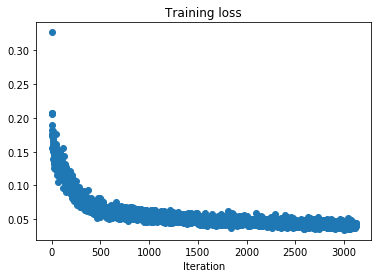

Done


In [8]:
# train!
exp_name = 'exp15'
model = DeepInverse(train_set.phi.shape)
learning_rate = 5e-4
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(model, optimizer, epochs=5, logdir='runs/' + exp_name + '_1')

print("Done")

Run `tensorboard --logdir=runs/exp15_2 --host=127.0.0.1` to visualize in realtime
-----------------------------
* epoch 1/5
Iteration 0, loss = 0.0401

Iteration 100, loss = 0.0407

Iteration 200, loss = 0.0380

Iteration 300, loss = 0.0435

Iteration 400, loss = 0.0412

Iteration 500, loss = 0.0433

Iteration 600, loss = 0.0398

-----------------------------
* epoch 2/5
Iteration 0, loss = 0.0383

Iteration 100, loss = 0.0383

Iteration 200, loss = 0.0390

Iteration 300, loss = 0.0417

Iteration 400, loss = 0.0414

Iteration 500, loss = 0.0422

Iteration 600, loss = 0.0380

-----------------------------
* epoch 3/5
Iteration 0, loss = 0.0404

Iteration 100, loss = 0.0415

Iteration 200, loss = 0.0434

Iteration 300, loss = 0.0405

Iteration 400, loss = 0.0366

Iteration 500, loss = 0.0355

Iteration 600, loss = 0.0400

-----------------------------
* epoch 4/5
Iteration 0, loss = 0.0412

Iteration 100, loss = 0.0430

Iteration 200, loss = 0.0397

Iteration 300, loss = 0.0355

Iteratio

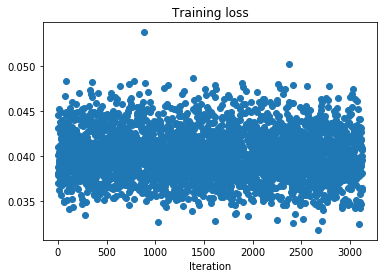

Done


In [9]:
# adjust lr and continue
learning_rate = 1e-5
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train(model, optimizer, epochs=5, logdir='runs/' + exp_name + '_2')
print("Done")

In [10]:
# Save the state_dict of the model
fname_sdict = 'pytorch-cifar10_csdl_gray.pt'
fname_phi = 'pytorch-cifar10_csdl_gray-measurement.pickle'
torch.save(model.state_dict(), fname_sdict)
with open(fname_phi, 'wb') as f:
    pickle.dump(train_set.phi, f)

# to load the model, use the following code:
# model = DeepInverse(train_set.phi.shape)
# model.load_state_dict(torch.load(fname_sdict))
# model.eval()
# with open(fname_phi, 'rb') ad f:
#     phi = pickle.dump(f)
# print('trained model loaded')

print("Done")

Done


torch.Size([64, 1, 32, 32])
torch.Size([64, 1, 32, 32])
_im is [[0.30736487 0.25775798 0.2132014  ... 0.22632983 0.28469259 0.34530433]
 [0.24650526 0.18883309 0.14180648 ... 0.17533547 0.24460399 0.3207161 ]
 [0.19128257 0.13041866 0.09071404 ... 0.14534894 0.21846732 0.30571978]
 ...
 [0.26389268 0.22430503 0.2273165  ... 0.31279622 0.3538653  0.39894001]
 [0.32886828 0.30581161 0.31351298 ... 0.25391638 0.31170048 0.37449604]
 [0.39076011 0.37771779 0.38472147 ... 0.27029334 0.32724187 0.38757694]]
_ori is [[0.11764705 0.10980392 0.12549019 ... 0.12941176 0.29411766 0.3019608 ]
 [0.10196078 0.10588235 0.10980392 ... 0.05490196 0.25098041 0.33333334]
 [0.03921568 0.04705882 0.05098039 ... 0.02352941 0.23137254 0.35294119]
 ...
 [0.07843137 0.03529412 0.02745098 ... 0.42745098 0.46666667 0.4509804 ]
 [0.18431371 0.40000001 0.31764707 ... 0.25490198 0.27058825 0.19607842]
 [0.3019608  0.53333336 0.55686277 ... 0.18823528 0.32549021 0.42745098]]
the original image: mx = 0.92941176891326

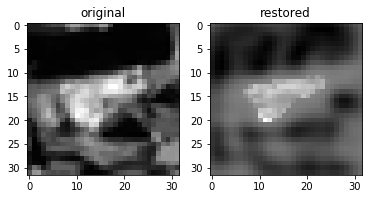

In [17]:
# Visualize the recovered and original image
def denormalize(im):
    if im.shape[2] == 1: # grayscale
        mean, std = (0.5,), (0.5,)
        im = im.reshape(im.shape[0], im.shape[1])
        im = im * std[0] + mean[0]
    else: # rgb
        mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        for ch in range(3):
            im[:,:,ch] = im[:,:,ch] * std[ch] + mean[ch]
    return im

# test
# Have a look at what the loader would return
# test_iter = iter(loader_test)
# _y, _x = test_iter.next()

test_iter = iter(loader_test)
_y, _x = test_iter.next()
print(_y.shape)

idx = 62
with torch.no_grad():
    _y = _y.to(device=device, dtype=dtype)
    restored_im = model(_y)
print(restored_im.shape)
_im = restored_im[idx].cpu().numpy()
_im = _im.transpose(1, 2, 0).astype(np.float)
_ori = _x[idx].cpu().numpy()
_ori = _ori.transpose(1, 2, 0).astype(np.float)
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

# _im[_im < -1] = -1.0
# _im[_im > 1] = 1.0
_im = denormalize(_im)
_ori = denormalize(_ori)
# im_mx = np.amax(_im)
# im_mn = np.amin(_im)
# _im = _im / (im_mx-im_mn) * 1.0

print(f'_im is {_im}')
print(f'_ori is {_ori}')


print(f"the original image: mx = {np.amax(_ori)}, mn={np.amin(_ori)}")
print(f"the restored image: mx = {np.amax(_im)}, mn={np.amin(_im)}")
plt.subplot(1,2,1)
plt.imshow(_ori, cmap="gray"); plt.title('original')
plt.subplot(1,2,2)
plt.imshow(_im, cmap="gray"); plt.title('restored')
plt.show()

In [20]:
# Calculate PSNR
def test(model, testing_data_loader, dev):
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            measurement, original = batch[0].to(dev), batch[1].to(dev)

            recovered = model(measurement)
            mse = F.mse_loss(recovered, original)
            psnr = 10 * np.log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

test(model, loader_test, device)

===> Avg. PSNR: 13.9927 dB
